<a href="https://colab.research.google.com/github/sinajahangir/HydrologicalDL_Colab/blob/main/KAN_Hydrology_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries and read data

In [1]:
#import necessary libraries
import numpy as np
#for plotting
import matplotlib.pyplot as plt
#KAN netwrok
!pip install tfkan
!pip install tf_keras==2.15
!pip install tensorflow_probability==0.23.0
import tensorflow_probability as tfp
import os
import tfkan
import tensorflow as tf
#reading csv files
import pandas as pd

In [2]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Change directory to where input data is saved
os.chdir('/content/drive/MyDrive/CARD_Hydrology')

In [4]:
#change path
#train data
csv_path='CamelsRegionaltrain_0_camels_01022500.csv'
df = pd.read_csv(csv_path)
df=df.dropna()
#change path
#test data
csv_path_test='CamelsRegionaltest_0_camels_01022500.csv'
df_test = pd.read_csv(csv_path_test)

mean_=np.asarray(df.iloc[:,1:].mean())
std_=np.asarray(df.iloc[:,1:].std())

#transfrom data
df_test_tr=df_test.iloc[:,1:]-mean_
df_test_tr=df_test_tr/(std_)
df_test_tr=df_test_tr.drop(columns=['basin_id'])
df_test_tr['basin_id'] = df_test['basin_id']
mean_q=df['q'].mean()
std_q=df['q'].std()
df_tr = df.iloc[:,1:].apply(lambda x: (x-x.mean())/(x.std()), axis=0)

In [5]:
#print transformed test data
df_test_tr

,pr,srad,tmax,tmin,vp,q,average_pr,average_q,average_tmax,average_tmin,basin_id
0,-0.473552,-1.064105,-1.159628,-1.000030,-1.014460,-0.111022,0.000729,-0.003809,0.006756,0.002457,0
1,-0.473552,-1.070815,-0.673509,-0.507607,-0.712332,-0.174008,0.000729,-0.003809,0.006756,0.002457,0
2,2.399008,-1.552969,-0.363989,0.005664,-0.300331,0.275288,0.000729,-0.003809,0.006756,0.002457,0
3,-0.473552,-0.968504,-0.517799,-0.509593,-0.732651,0.628006,0.000729,-0.003809,0.006756,0.002457,0
4,-0.457161,-0.926131,-0.896630,-0.956347,-0.998872,0.502035,0.000729,-0.003809,0.006756,0.002457,0
...,...,...,...,...,...,...,...,...,...,...,...
1508,-0.473552,-0.638121,-1.121650,-1.384239,-1.172488,-0.299978,0.000729,-0.003809,0.006756,0.002457,0
1509,-0.473552,-1.166944,-1.590678,-1.265105,-1.115442,-0.350367,0.000729,-0.003809,0.006756,0.002457,0
1510,0.519482,-1.309215,-0.976384,-0.793530,-0.900348,-0.299978,0.000729,-0.003809,0.006756,0.002457,0
1511,-0.133434,-1.048423,-0.797887,-0.828278,-0.921199,-0.249590,0.000729,-0.003809,0.006756,0.002457,0


#Error Metrics

In [6]:
def nash_sutcliffe_error(Q_obs,Q_sim):
    """
    Written by: SJ
    Q_obs: observed discharge; 1D vector
    Q_sim: simulated discharge; 1D vector
    This function calculates the NSE between observed and simulated discharges
    returns: NSE; float
    """
    if len(Q_sim)!=len(Q_obs):
        print('Length of simulated and observed discharges do not match')
        return
    else:
        num=np.sum(np.square(Q_sim-Q_obs))
        den=np.sum(np.square(Q_obs-np.mean(Q_obs)))
        NSE=1-(num/den)
        return NSE

def CC(Pr,Y):
    from scipy import stats
    Pr=np.reshape(Pr,(-1,1))
    Y=np.reshape(Y,(-1,1))
    return stats.pearsonr(Pr.flatten(),Y.flatten())[0]
def KGE(prediction,observation):

    nas = np.logical_or(np.isnan(prediction), np.isnan(observation))
    pred=np.copy(np.reshape(prediction,(-1,1)))
    obs=np.copy(np.reshape(observation,(-1,1)))
    r=CC(pred[~nas],obs[~nas])
    beta=np.nanmean(pred)/np.nanmean(obs)
    gamma=(np.nanstd(pred)/np.nanstd(obs))/beta
    kge=1-((r-1)**2+(beta-1)**2+(gamma-1)**2)**0.5
    return kge

# Reshaping input data to 3D

In [7]:
def split_sequence_multi_train(sequence_x,sequence_y, n_steps_in, n_steps_out,mode='seq'):
    """
    written by:SJ
    sequence_x=features; 2D array
    sequence_y=target; 2D array
    n_steps_in=IL(lookbak period);int
    n_steps_out=forecast horizon;int
    mode:either single (many to one) or seq (many to many).
    This function creates an output in shape of (sample,IL,feature) for x and
    (sample,n_steps_out) for y
    """
    X, y = list(), list()
    k=0
    sequence_x=np.copy(np.asarray(sequence_x))
    sequence_y=np.copy(np.asarray(sequence_y))
    for _ in range(len(sequence_x)):
		# find the end of this pattern
        end_ix = k + n_steps_in
        out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
        if out_end_ix > len(sequence_x):
            break
		# gather input and output parts of the pattern
        seq_x = sequence_x[k:end_ix]
        #mode single is used for one output
        if n_steps_out==0:
            seq_y= sequence_y[end_ix-1:out_end_ix]
        elif mode=='single':
            seq_y= sequence_y[out_end_ix-1]
        else:
            seq_y= sequence_y[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y.flatten())
        k=k+1

    XX,YY= np.asarray(X), np.asarray(y)
    if (n_steps_out==0 or n_steps_out==1):
        YY=YY.reshape((len(XX),1))
    return XX,YY

In [8]:
ii=0
# reshape data
temp_x=np.asarray(df_tr[df['basin_id']==ii].loc[:, ['pr', 'srad', 'tmax', 'tmin', 'vp', 'average_pr',
           'average_q', 'average_tmax', 'average_tmin']])
temp_y=np.asarray(df_tr[df['basin_id']==ii]['q']).reshape((-1,1))
xx,yy=split_sequence_multi_train(temp_x,temp_y,365,0,mode='seq')


# train data
x_train=xx[:int(0.9*len(xx))]
y_train=yy[:int(0.9*len(xx))]
# validation data
x_val=xx[int(0.9*len(xx)):]
y_val=yy[int(0.9*len(xx)):]

#Define the model

## Define the KAN DL

In [17]:
inputs = tf.keras.layers.Input(shape=(365, 9))
x_ = tf.keras.layers.LSTM(128, return_sequences=False)(inputs)
x_.trainable=True
x=tf.keras.layers.Dropout(0.1)(x_)
outputs = tf.keras.layers.Dense(1,activation='linear')(x)
modeli = tf.keras.Model(inputs, outputs)
modeli.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss="mse")
#load pre-trained model weights
modeli.load_weights('Final_sim2_0.h5')
nn_without_head = tf.keras.models.Model(inputs=modeli.inputs, outputs=x)
nn_without_head.trainable=True
# The deterministic approach
dense_kan=tf.keras.layers.TimeDistributed(tfkan.layers.DenseKAN(1))(nn_without_head.input)
dense_kan=tf.keras.layers.Flatten()(dense_kan)
concat_layer=tf.keras.layers.Concatenate()([dense_kan,nn_without_head.output])
dense_layer=tf.keras.layers.Dense(1)(concat_layer)
model_KAN = tf.keras.models.Model(inputs=nn_without_head.input, outputs=dense_layer)
model_KAN.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss='mse')
# Print the new model summary to verify
model_KAN.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 365, 9)]             0         []                            
                                                                                                  
 time_distributed_4 (TimeDi  (None, 365, 1)               190       ['input_5[0][0]']             
 stributed)                                                                                       
                                                                                                  
 lstm_4 (LSTM)               (None, 128)                  70656     ['input_5[0][0]']             
                                                                                                  
 flatten_3 (Flatten)         (None, 365)                  0         ['time_distributed_4[0]

In [18]:
early_call  = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
model_KAN.fit(x=x_train,y=y_train,epochs=100,validation_data=(x_val,y_val),callbacks=[early_call,reduce_callback])

Epoch 1/100
231/231 [==============================] - 7s 20ms/step - loss: 0.5982 - val_loss: 0.4811 - lr: 0.0010
Epoch 2/100
231/231 [==============================] - 5s 22ms/step - loss: 0.2097 - val_loss: 0.3324 - lr: 0.0010
Epoch 3/100
231/231 [==============================] - 4s 17ms/step - loss: 0.1198 - val_loss: 0.2937 - lr: 0.0010
Epoch 4/100
231/231 [==============================] - 4s 16ms/step - loss: 0.0916 - val_loss: 0.2500 - lr: 0.0010
Epoch 5/100
231/231 [==============================] - 5s 20ms/step - loss: 0.0776 - val_loss: 0.2141 - lr: 0.0010
Epoch 6/100
231/231 [==============================] - 6s 25ms/step - loss: 0.0670 - val_loss: 0.2690 - lr: 0.0010
Epoch 7/100
231/231 [==============================] - 4s 17ms/step - loss: 0.0535 - val_loss: 0.3031 - lr: 0.0010
Epoch 8/100
231/231 [==============================] - 4s 19ms/step - loss: 0.0480 - val_loss: 0.2862 - lr: 0.0010
Epoch 9/100
231/231 [==============================] - 4s 19ms/step - loss: 0.04

In [19]:
ii=0
temp_xx=np.asarray(df_test_tr[df_test_tr['basin_id']==ii].loc[:, ['pr', 'srad', 'tmax', 'tmin', 'vp', 'average_pr',
            'average_q', 'average_tmax', 'average_tmin']])
temp_yy=np.asarray(df_test_tr[df_test_tr['basin_id']==ii]['q']).reshape((-1,1))
xx_,yy_=split_sequence_multi_train(temp_xx,temp_yy,365,0,mode='seq')

36/36 [==============================] - 1s 10ms/step


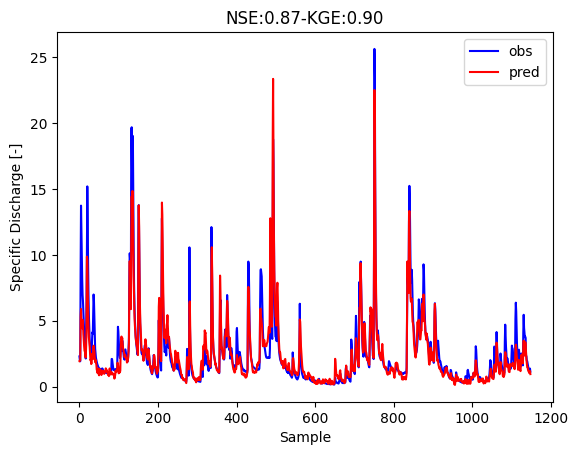

In [20]:
#transform y_test
y_test=yy_*std_q+mean_q
plt.plot(y_test,c='b',label='obs')
for ii in range(0,1):
  pred_test=model_KAN.predict(xx_)
  pred_test=pred_test*std_q+mean_q
  plt.plot(pred_test,c='r',label='pred')

  nse=nash_sutcliffe_error(y_test,pred_test)
  kge=KGE(pred_test,y_test)
  plt.title('NSE:%1.2f'%(nse)+ '-KGE:%1.2f'%(kge))
  plt.legend()

  plt.xlabel('Sample')
  plt.ylabel('Specific Discharge [-]')

## Benchmarking CAMELS-US


In [44]:
#read the data with all catchments
csv_path_train='/content/drive/MyDrive/PHIMP/All421_TrainTest/All421data_Train_v1.csv'
csv_path_test='/content/drive/MyDrive/PHIMP/All421_TrainTest/All421data_Test_v1.csv'
df_train = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

In [45]:
mean_=np.asarray(df_train.iloc[:,1:].mean())
std_=np.asarray(df_train.iloc[:,1:].std())

df_test_tr=df_test.iloc[:,1:]-mean_
df_test_tr=df_test_tr/std_
df_test_tr=df_test_tr.drop(columns=['basin_id'])
df_test_tr['basin_id'] = df_test['basin_id']

mean_q=df_train['q'].mean()
std_q=df_train['q'].std()

#transformed data
df_tr = df_train.iloc[:,1:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [69]:
flag=True
for jj in range(0,1):
  list_=list(pd.read_csv("/content/drive/MyDrive/PHIMP/random_numbers_sim_%d.csv"%(jj)).iloc[:,1])
  for ii in range(0,421):
    inputs = tf.keras.layers.Input(shape=(365, 9))
    x_ = tf.keras.layers.LSTM(128, return_sequences=False)(inputs)
    x_.trainable=flag
    x=tf.keras.layers.Dropout(0.1)(x_)
    outputs = tf.keras.layers.Dense(1,activation='linear')(x)
    modeli = tf.keras.Model(inputs, outputs)
    modeli.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss="mse")



    #load pre-trained model weights
    modeli.load_weights('Final_sim2_0.h5')
    nn_without_head = tf.keras.models.Model(inputs=modeli.inputs, outputs=x)
    nn_without_head.trainable=flag

    # The deterministic approach
    dense_kan=tf.keras.layers.TimeDistributed(tfkan.layers.DenseKAN(1))(nn_without_head.input)
    dense_kan=tf.keras.layers.Flatten()(dense_kan)
    concat_layer=tf.keras.layers.Concatenate()([dense_kan,nn_without_head.output])
    dense_layer=tf.keras.layers.Dense(1)(concat_layer)
    model_KAN = tf.keras.models.Model(inputs=nn_without_head.input, outputs=dense_layer)
    model_KAN.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss='mse')


    # Print the new model summary to verify
    model_KAN.summary()
    temp_x=np.asarray(df_tr[df_train['basin_id']==ii].loc[:, ['pr', 'srad', 'tmax', 'tmin', 'vp', 'average_pr',
            'average_q', 'average_tmax', 'average_tmin']])
    temp_y=np.asarray(df_tr[df_train['basin_id']==ii]['q']).reshape((-1,1))
    xx,yy=split_sequence_multi_train(temp_x,temp_y,365,0,mode='seq')


    early_call  = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    reduce_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
    model_KAN.fit(x=xx,y=yy,epochs=100,validation_split=0.1,callbacks=[early_call,reduce_callback])


    temp_xx=np.asarray(df_test_tr[df_test_tr['basin_id']==ii].loc[:, ['pr', 'srad', 'tmax', 'tmin', 'vp', 'average_pr',
            'average_q', 'average_tmax', 'average_tmin']])
    temp_yy=np.asarray(df_test_tr[df_test_tr['basin_id']==ii]['q']).reshape((-1,1))
    xx_,yy_=split_sequence_multi_train(temp_xx,temp_yy,365,0,mode='seq')

    y_out_tr=yy_[:,0]
    #obtating the prediction
    y_pred_tr=model_KAN.predict(xx_)
    y_m_out_tr=y_pred_tr

    #transforming to the original space
    y_out_tr=y_out_tr*std_q+mean_q
    y_m_out_tr=y_m_out_tr*std_q+mean_q

    if ii in list_:
      with open('/content/drive/MyDrive/PHIMP/KAN_Regional_Same.csv', 'a') as f:
            f.write(f'{ii},{nash_sutcliffe_error(y_out_tr.reshape((-1,1)),y_m_out_tr)},{KGE(y_m_out_tr,y_out_tr.reshape((-1,1)))}\n')
      f.close()
    else:
      with open('/content/drive/MyDrive/PHIMP/KAN_Regional_Diff.csv', 'a') as f:
            f.write(f'{ii},{nash_sutcliffe_error(y_out_tr.reshape((-1,1)),y_m_out_tr)},{KGE(y_m_out_tr,y_out_tr.reshape((-1,1)))}\n')
      f.close()

Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 365, 9)]             0         []                            
                                                                                                  
 time_distributed_15 (TimeD  (None, 365, 1)               190       ['input_16[0][0]']            
 istributed)                                                                                      
                                                                                                  
 lstm_15 (LSTM)              (None, 128)                  70656     ['input_16[0][0]']            
                                                                                                  
 flatten_14 (Flatten)        (None, 365)                  0         ['time_distributed_15[0

KeyboardInterrupt: 

In [50]:
nash_sutcliffe_error(y_out_tr,y_m_out_tr)

-2054.777411427718

In [61]:
KGE(y_m_out_tr,y_out_tr)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 1 but corresponding boolean dimension is 1149

In [35]:
y_out_tr=yy_[:,0]

#obtating the prediction

y_pred_tr=model_KAN.predict(xx_)
y_m_out_tr=y_pred_tr

#transforming to the original space

y_out_tr=y_out_tr*std_q+mean_q
y_m_out_tr=y_m_out_tr*std_q+mean_q

36/36 [==============================] - 3s 86ms/step


In [40]:
np.sum(np.isnan(y_m_out_tr))

0

In [67]:
nash_sutcliffe_error(y_out_tr.reshape((-1,1)),y_m_out_tr)

0.8540588182479807

In [31]:
print(y_m_out_tr)

[[1.8194739 ]
 [1.7402226 ]
 [1.7260013 ]
 ...
 [1.0516431 ]
 [1.0500925 ]
 [0.88069904]]


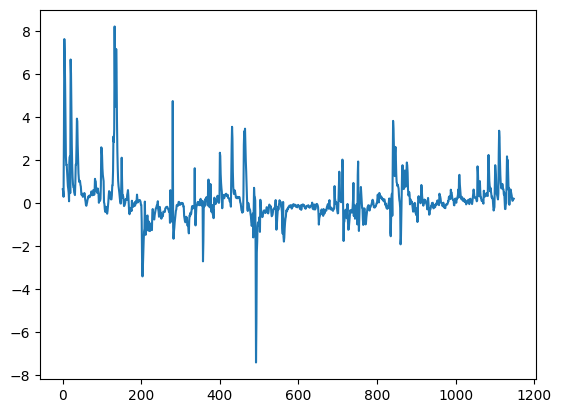

In [66]:
plt.plot(y_out_tr.reshape((-1,1))-y_m_out_tr)

In [55]:
np.mean(y_out_tr)

2.5171018276762402

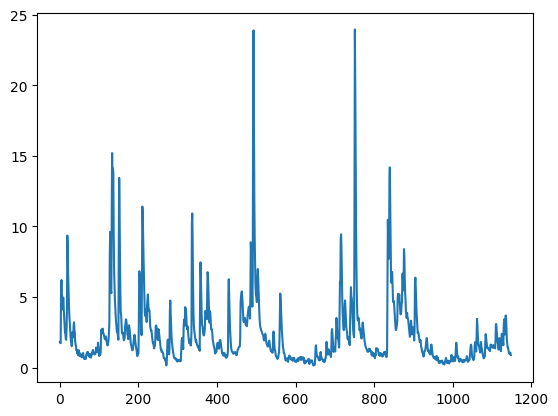

In [32]:
plt.plot(y_m_out_tr)

#Probabilistic Modeling

In [ ]:
def nll(y_true,y_pred):
  """
  Written by:SJ
  Negative log likelihood
  y_true:observation;2D array
  y_pred:prediction;2D array
  """
  return -y_pred.log_prob(y_true)

In [ ]:
from tensorflow_probability import distributions as tfd
inputs = tf.keras.layers.Input(shape=(365, 9))
x_ = tf.keras.layers.LSTM(128, return_sequences=False)(inputs)
x_.trainable=True
x=tf.keras.layers.Dropout(0.1)(x_)
outputs = tf.keras.layers.Dense(1,activation='linear')(x)
modeli = tf.keras.Model(inputs, outputs)
modeli.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss="mse")
#load pre-trained model weights
modeli.load_weights('Final_sim2_0.h5')
nn_without_head = tf.keras.models.Model(inputs=modeli.inputs, outputs=x)
nn_without_head.trainable=True
# The deterministic approach
dense_layer=tfkan.layers.DenseKAN(15)(nn_without_head.output)
dense_layer=tfp.layers.MixtureNormal(num_components=5,event_shape=1,convert_to_tensor_fn=tfd.Distribution.sample)(dense_layer)
#dense_layer=tfkan.layers.DenseKAN(1)(dense_layer)
model_KAN = tf.keras.models.Model(inputs=nn_without_head.input, outputs=dense_layer)
model_KAN.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss='mse')
# Print the new model summary to verify
model_KAN.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 365, 9)]          0         
                                                                 
 lstm_14 (LSTM)              (None, 128)               70656     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_kan_17 (DenseKAN)     (None, 15)                18831     
                                                                 
 mixture_normal_3 (MixtureN  ((None, 1),               0         
 ormal)                       (None, 1))                         
                                                                 
Total params: 89487 (349.56 KB)
Trainable params: 87951 (343.56 KB)
Non-trainable params: 1536 (6.00 KB)
___________________

In [ ]:
early_call  = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
model_KAN.fit(x=x_train,y=y_train,epochs=100,validation_data=(x_val,y_val),callbacks=[early_call,reduce_callback])

Epoch 1/100
231/231 [==============================] - 18s 57ms/step - loss: 0.4856 - val_loss: 0.5458 - lr: 0.0010
Epoch 2/100
231/231 [==============================] - 11s 47ms/step - loss: 0.1953 - val_loss: 0.3533 - lr: 0.0010
Epoch 3/100
231/231 [==============================] - 12s 54ms/step - loss: 0.1536 - val_loss: 0.2813 - lr: 0.0010
Epoch 4/100
231/231 [==============================] - 11s 49ms/step - loss: 0.1280 - val_loss: 0.2966 - lr: 0.0010
Epoch 5/100
231/231 [==============================] - 13s 57ms/step - loss: 0.1162 - val_loss: 0.2355 - lr: 0.0010
Epoch 6/100
231/231 [==============================] - 13s 57ms/step - loss: 0.0955 - val_loss: 0.2043 - lr: 0.0010
Epoch 7/100
231/231 [==============================] - 16s 68ms/step - loss: 0.0774 - val_loss: 0.2233 - lr: 0.0010
Epoch 8/100
231/231 [==============================] - 12s 50ms/step - loss: 0.0721 - val_loss: 0.2252 - lr: 0.0010
Epoch 9/100
231/231 [==============================] - 15s 64ms/step - l

Text(0, 0.5, 'Specific Discharge [-]')

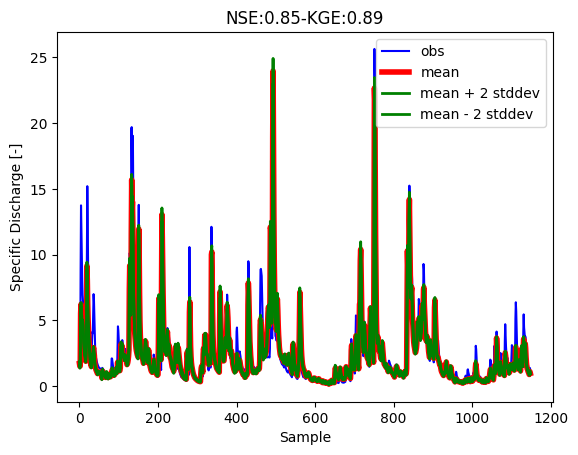

In [ ]:
#transform y_test
y_test=yy_*std_q+mean_q
plt.plot(y_test,c='b',label='obs')
predictions=[]
for ii in range(0,1):
  pred_test=model_KAN(xx_)
  m = pred_test.mean()
  s = pred_test.stddev()

  mean=m*std_q+mean_q
  up=(m+2*s)*std_q+mean_q
  down=(m-2*s)*std_q+mean_q
  predictions.append(mean_)
  plt.plot(mean, 'r', linewidth=4, label='mean');
  plt.plot(up, 'g', linewidth=2, label=r'mean + 2 stddev');
  plt.plot(down, 'g', linewidth=2, label=r'mean - 2 stddev');

nse=nash_sutcliffe_error(y_test,mean)
kge=KGE(mean,y_test)
plt.title('NSE:%1.2f'%(nse)+ '-KGE:%1.2f'%(kge))
plt.legend()

plt.xlabel('Sample')
plt.ylabel('Specific Discharge [-]')


In [ ]:
print(up)

tf.Tensor(
[[1.8280466 ]
 [1.6576927 ]
 [1.6988785 ]
 ...
 [0.96624315]
 [1.0988054 ]
 [0.9170017 ]], shape=(1149, 1), dtype=float32)


In [ ]:
print(mean)

tf.Tensor(
[[1.7374855 ]
 [1.5427557 ]
 [1.5757916 ]
 ...
 [0.92250216]
 [1.040647  ]
 [0.86896944]], shape=(1149, 1), dtype=float32)


In [ ]:
predictions_mean=np.nanmean(pred_test,axis=1)

In [ ]:
model_ema_trained=model.network
list_=[]
#%%
#Sample from the model iteratively
for ii in range(0,10):
  samples= tf.random.normal(
            shape=(len(xx_), 1), dtype=tf.float32)
  for t in reversed(range(0, total_timesteps)):
      tt = tf.cast(tf.fill(len(xx_), t), dtype=tf.int64)
      pred_noise = model_ema_trained.predict(
          [samples,xx_m_, tt,xx_])
      samples = gdf_util.p_sample(
                  pred_noise, samples, tt,xx_m_, clip_denoised=True)
  list_.append(samples)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━

In [ ]:
def RMSE(Pr,Y):
    Pr=np.reshape(Pr,(-1,1))
    Y=np.reshape(Y,(-1,1))
    rmse=(np.nanmean(((Pr-Y)**2)))**0.5
    return rmse
def reliability_quantile(observation,up_percentile,low_percentile):
    width=np.nanmean(up_percentile-low_percentile)
    id_1=observation<=up_percentile
    id_2=id_1[observation>=low_percentile]
    total_id=id_2
    temp_len=np.nansum(total_id)
    return temp_len/len(observation)*100,width

In [ ]:
def nash(Q_obs,Q_sim):
    """
    Written by: SJ
    Q_obs: observed discharge; 1D vector
    Q_sim: simulated discharge; 1D vector
    This function calculates the NSE between observed and simulated discharges
    returns: NSE; float
    """
    if len(Q_sim)!=len(Q_obs):
        print('Length of simulated and observed discharges do not match')
        return
    else:
        num=np.sum(np.square(Q_sim-Q_obs))
        den=np.sum(np.square(Q_obs-np.mean(Q_obs)))
        NSE=1-(num/den)
        return NSE

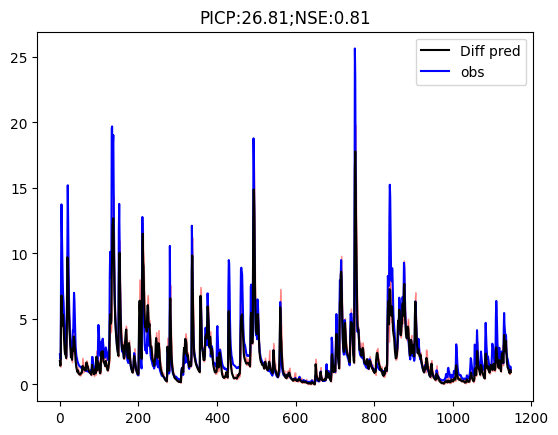

In [ ]:
#%%
array_total=np.asarray(list_)
median=np.median(array_total,axis=0)
up=np.percentile(array_total,95,axis=0)
down=np.percentile(array_total,5,axis=0)
samples_array=np.asarray(median)



target=yy_*std_q+mean_q
pred_=median*std_q+mean_q
pred_low=down*std_q+mean_q
pred_up=up*std_q+mean_q





picp,width=reliability_quantile(target,pred_up,pred_low)
nse_pred=nash(target,pred_)


#%%
plt.plot(pred_,'k',zorder=4,label='Diff pred')
plt.plot(target,'b',zorder=3,label='obs')
#plt.plot(mean_,'green',zorder=2)
plt.fill_between(np.arange(len(pred_)),pred_low.ravel(),pred_up.ravel(),color='r',alpha=0.4,zorder=1)
plt.title('PICP:%1.2f;'%(picp)+ 'NSE:%1.2f'%(nse_pred))
plt.legend()